# Chapter 14 -Deep Computer Vision Using Convolutional Neural Networks Code Reproduction

In [1]:
# Impor umum
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Memuat gambar sampel
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

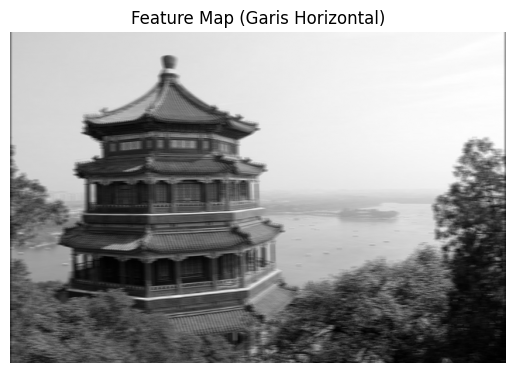

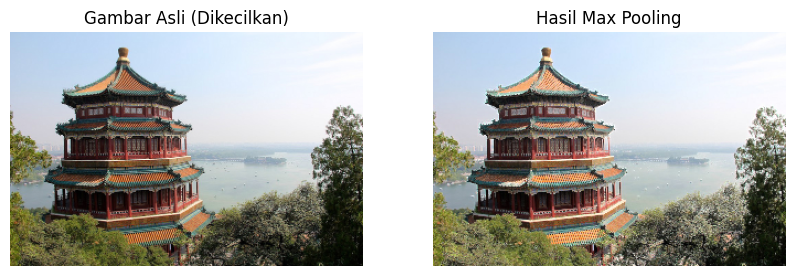

In [2]:
# Membuat 2 filter 7x7 secara manual
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # filter garis vertikal
filters[3, :, :, 1] = 1  # filter garis horizontal

# Menerapkan filter menggunakan operasi konvolusi TensorFlow
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

# Memvisualisasikan salah satu feature map
plt.imshow(outputs[0, :, :, 1], cmap="gray") # Plot feature map kedua dari gambar pertama
plt.axis("off")
plt.title("Feature Map (Garis Horizontal)")
plt.show()


# Implementasi Max Pooling
max_pool = keras.layers.MaxPool2D(pool_size=2)
# Di TensorFlow level rendah:
# outputs_pool = tf.nn.max_pool(images, ksize=[1, 1, 1, 2], strides=[1, 1, 1, 2], padding="VALID")

# Membuat gambar hasil pooling untuk visualisasi
cropped_images = np.array([
    tf.image.resize(image, [height // 2, width // 2]).numpy()
    for image in images
])
pooled_images_tf = max_pool(tf.constant(images))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cropped_images[0])
plt.title("Gambar Asli (Dikecilkan)")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(pooled_images_tf[0])
plt.title("Hasil Max Pooling")
plt.axis("off")
plt.show()

In [3]:
# Memuat dan menyiapkan dataset Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Melakukan scaling dan menambahkan dimensi channel
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Membangun model CNN menggunakan Keras Sequential API
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

# Kompilasi, latih, dan evaluasi model
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
# score = model.evaluate(X_test, y_test)
# print("\nHasil evaluasi CNN pada test set:", score)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Membuat layer Residual Unit (Blok Residual)
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

# Membangun model ResNet-34
model_resnet = keras.models.Sequential()
model_resnet.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], padding="same", use_bias=False))
model_resnet.add(keras.layers.BatchNormalization())
model_resnet.add(keras.layers.Activation("relu"))
model_resnet.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model_resnet.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model_resnet.add(keras.layers.GlobalAvgPool2D())
model_resnet.add(keras.layers.Flatten())
model_resnet.add(keras.layers.Dense(10, activation="softmax")) # Asumsi 10 kelas output

model_resnet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit (ResidualUnit)         │ (None, 56, 56, 64)          │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_1 (ResidualUnit)       │ (None, 56, 56, 64)          │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_2 (ResidualUnit)       │ (None, 56, 56, 64)          │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_3 (ResidualUnit)       │ (None, 28, 28, 128)         │         230,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_4 (ResidualUnit)       │ (None, 28, 28, 128)         │         295,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_5 (ResidualUnit)       │ (None, 28, 28, 128)         │         295,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_6 (ResidualUnit)       │ (None, 28, 28, 128)         │         295,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_7 (ResidualUnit)       │ (None, 14, 14, 256)         │         920,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_8 (ResidualUnit)       │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_9 (ResidualUnit)       │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_10 (ResidualUnit)      │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_11 (ResidualUnit)      │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_12 (ResidualUnit)      │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_13 (ResidualUnit)      │ (None, 7, 7, 512)           │       3,676,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_14 (ResidualUnit)      │ (None, 7, 7, 512)           │       4,722,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_15 (ResidualUnit)      │ (None, 7, 7, 512)           │       4,722,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │              

 Total params: 21,306,826 (81.28 MB)

 Trainable params: 21,289,802 (81.21 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [5]:
# Memuat model ResNet-50 yang sudah dilatih
model_pretrained = keras.applications.resnet50.ResNet50(weights="imagenet")

# Memuat gambar sampel dan menyesuaikan ukurannya
img = tf.image.resize(images[0], [224, 224])
img = img[np.newaxis, ...] # Tambahkan dimensi batch

# Melakukan pra-pemrosesan sesuai kebutuhan ResNet-50
inputs = keras.applications.resnet50.preprocess_input(img * 255)

# Membuat prediksi
Y_proba = model_pretrained.predict(inputs)

# Menampilkan 3 prediksi teratas
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
print("\nPrediksi teratas dari model pre-trained:")
for class_id, name, y_proba in top_K[0]:
    print("  {} - {} {:.2f}%".format(class_id, name, y_proba * 100))

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Prediksi teratas dari model pre-trained:
  n02825657 - bell_cote 82.35%
  n03877845 - palace 6.75%
  n03781244 - monastery 4.19%


In [6]:
# (Asumsikan 'tfds' sudah diinstal dan dataset bunga dimuat)
# import tensorflow_datasets as tfds
# dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
# ... (kode pra-pemrosesan dataset bunga)

# 1. Memuat model dasar (Xception) tanpa lapisan atas (klasifikasi)
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)

# 2. Menambahkan lapisan atas baru yang sesuai dengan tugas kita
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(5, activation="softmax")(avg) # 5 kelas bunga
model_transfer = keras.Model(inputs=base_model.input, outputs=[output])

# 3. Membekukan (freeze) bobot dari model dasar
for layer in base_model.layers:
    layer.trainable = False

# 4. Mengompilasi dan melatih model (hanya melatih lapisan atas baru)
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model_transfer.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# history_transfer = model_transfer.fit(train_set, epochs=5, validation_data=valid_set)

# 5. Fine-tuning: membuka kembali bobot model dasar dan melatih dengan learning rate rendah
# base_model.trainable = True
# optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
# model_transfer.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# history_fine_tune = model_transfer.fit(train_set, epochs=5, validation_data=valid_set)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
